In [1]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
from scipy.stats import powerlaw
from scipy import integrate
from scipy.special import gammaln
import time
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
%matplotlib inline

In [2]:
#Import my own functions:
import bayes
import simdat
import auto_corr
#arf_table = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
#arf = np.array(arf_table['ENERG_HI'])

Metropolis Hastings Algorithm Overview:
1. Create a function that can generate a large parameter space from which to draw samples. Take out a random value from this space, x' (x' is a vector containing values of the parameters)
2. Draw a random number r, such that 0<r<1
3. Calculate the posterior for those values of the parameters.
4. Compare the values of the posterior at x' to the value of the posterior at the previous step, x (if this is the first step, skip this part?)
5. If pdf(x')/pdf(x) > r: keep x' in your parameter space and move to the next point. otherwise, repeat for previous step value, x.

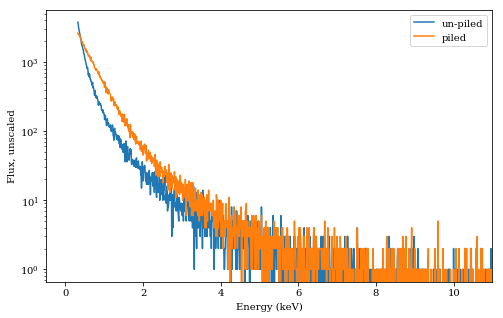

In [4]:
#energy_bins, energy_hist, piled_hist = simdat.simulate_data(500000,2.7,'cdf',arf)
simdat.plot_data(energy_bins,energy_hist, piled_hist)
plt.savefig('spectrum.pdf')

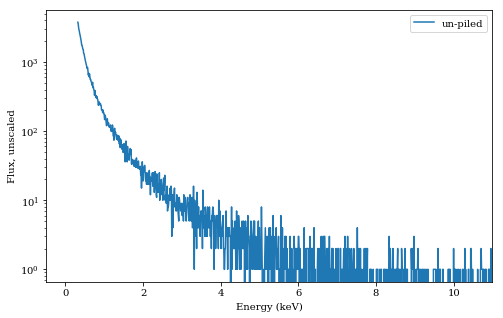

In [5]:
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(energy_bins,energy_hist,label='un-piled')
#ax.plot(e_bins,pe_hist,label='piled')
ax.set_xlabel('Energy (keV)')
ax.set_xlim(-0.5,11)
ax.set_ylabel('Flux, unscaled')
ax.set_yscale('log')
ax.legend()
plt.savefig('spectrum_unpiled.pdf')

In [7]:
#arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
ENERG_LO = np.array(arf_table['ENERG_LO'])
ENERG_HI = np.array(arf_table['ENERG_HI'])

In [13]:
#Initially, just do some number of iterations, before worrying about including autocorrelation
def metropolis_hastings(data,E_max,E_min,walk_length=1000000):
    step = 0
    converged = 0
    #Run scipy.optimize.minimize on negative log likelihood to get starting values for random walk
    init_params = [np.log(1000000),2.0]
    print('len(data)',len(data),'len(E_max)',len(E_max),'len(E_min)',len(E_min))
    opt = minimize(bayes.neg_log_likelihood,init_params,args=(data,E_max,E_min),method='Nelder-Mead',options={'disp': False})
    print('Starting values from scipy optimize: logA=',opt.x[0],'alpha=',opt.x[1])
    
    #Generate paramter space for logA and alpha
    sig_logA = 0.1 #These will need to be chosen more carefully eventually
    sig_a = 0.05 #These will need to be chosen more carefully eventually
        
    #Generate empty arrays for adding chain
    logA_vals = []
    alpha_vals = []
    post_vals = []
    
    #Define number of steps:
    #walk_length = 1000000
    
    #Take a random walk (in this case, just a finite number of steps)
    while step < walk_length:
        if step == 0:
            logA_vals.append(opt.x[0])
            alpha_vals.append(opt.x[1])
            log_like = bayes.log_likelihood([opt.x[0],opt.x[1]],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(opt.x[0])
            log_a_prior = bayes.log_prior_alpha(opt.x[1])
            running_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            post_vals.append(running_posterior)
            old_logA = opt.x[0]
            old_alpha = opt.x[1]
            print('Initial posterior value =',running_posterior)
            step += 1
            
        if step > 0:
            if step%(walk_length/10)==0:
                print('on step',step)
            new_logA = np.random.normal(loc=logA_vals[-1],scale=sig_logA,size=1)
            new_a = np.random.normal(loc=alpha_vals[-1],scale=sig_a,size=1)
            log_like = bayes.log_likelihood([new_logA,new_a],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(new_logA)
            log_a_prior = bayes.log_prior_alpha(new_a)
            new_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            
            r = np.random.uniform(0.0,1.0)
            
            if np.exp(new_posterior-running_posterior)>r:
                logA_vals.append(new_logA)
                alpha_vals.append(new_a)
                post_vals.append(new_posterior)
                running_posterior = new_posterior
                old_logA = new_logA
                old_alpha = new_a
                step += 1
            else:
                logA_vals.append(logA_vals[-1])
                alpha_vals.append(alpha_vals[-1])
                post_vals.append(post_vals[-1])
                step += 1
        
    #cutoff = trim_correlated([alpha_vals,logA_vals],num=len(alpha_vals))
    #print 'cutoff value =',cutoff
    #return_logA = logA_vals[cutoff:]
    #return_alpha = alpha_vals[cutoff:]
    #return_pos = post_vals[cutoff:]
    #return return_logA,return_alpha,return_pos
    return logA_vals, alpha_vals,post_vals

In [15]:
logA,alpha,posteriors=metropolis_hastings(energy_hist,ENERG_HI,ENERG_LO,walk_length=1000000)
logA_piled,alpha_piled,posteriors_piled=metropolis_hastings(piled_hist,ENERG_HI,ENERG_LO,walk_length=1000000)

('Starting values from scipy optimize: logA=', 9.7369390995613152, 'alpha=', 2.6998234178981768)
('Initial posterior value =', -2038.7761139921627)
('on step', 100000)
('on step', 200000)
('on step', 300000)
('on step', 400000)
('on step', 500000)
('on step', 600000)
('on step', 700000)
('on step', 800000)
('on step', 900000)
('Starting values from scipy optimize: logA=', 10.377692398166397, 'alpha=', 2.2333382339365597)
('Initial posterior value =', -7839.7127986408223)
('on step', 100000)
('on step', 200000)
('on step', 300000)
('on step', 400000)
('on step', 500000)
('on step', 600000)
('on step', 700000)
('on step', 800000)
('on step', 900000)


In [9]:
def trim_correlated(chains,num):
    #num = 10000
    logA_chain = chains[0][0:num]
    alpha_chain = chains[1][0:num]
    acf_logA = auto_corr.autocorr_func_1d(logA_chain)
    acf_alpha = auto_corr.autocorr_func_1d(alpha_chain)
    correlated_alpha = 1
    correlated_logA = 1
    for i in range(len(alpha_chain)):
        if (acf_alpha[i]<0.01)and(correlated_alpha==1):
            correlated_alpha = 0
            print 'alpha uncorrelated starting at',i,acf_alpha[i],acf_alpha[i-1]
            lim_alpha = i
    for j in range(len(logA_chain)):
        if (acf_logA[j]<0.01)and(correlated_logA==1):
            correlated_logA = 0
            print 'logA uncorrelated starting at',j,acf_logA[j],acf_logA[j-1]
            lim_logA = j
    fig,ax=plt.subplots(figsize=(7,7))
    it = np.arange(0,len(logA_chain),1)
    ax.plot(it,acf_alpha,label='alpha',linewidth=2)
    ax.plot(it,acf_logA,label='logA',linewidth=2)
    ax.set_xlabel('iteration',fontsize=16)
    ax.set_ylabel('autocorrelation function',fontsize=16)
    #ax.axvline(lim_alpha,linestyle='--')
    #ax.axvline(lim_logA,linestyle='--')
    #ax.set_xlim(-50,1000)
    ax.legend()
    if lim_logA > lim_alpha:
        ax.axvline(lim_logA,linestyle='--',color='r',label='uncorr')
        return lim_logA
    if lim_logA < lim_alpha:
        ax.axvline(lim_alpha,linestyle='--',color='r',label='uncorr')
        return lim_alpha

alpha uncorrelated starting at 496 0.00999772924263 0.0103206838721
logA uncorrelated starting at 436 0.00983544996819 0.0101229263239


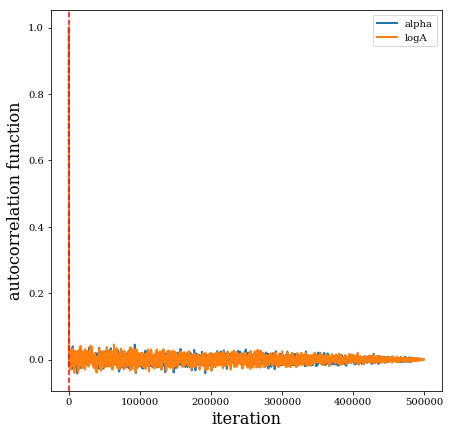

In [95]:
cutoff = trim_correlated([alpha,logA],num=len(alpha))

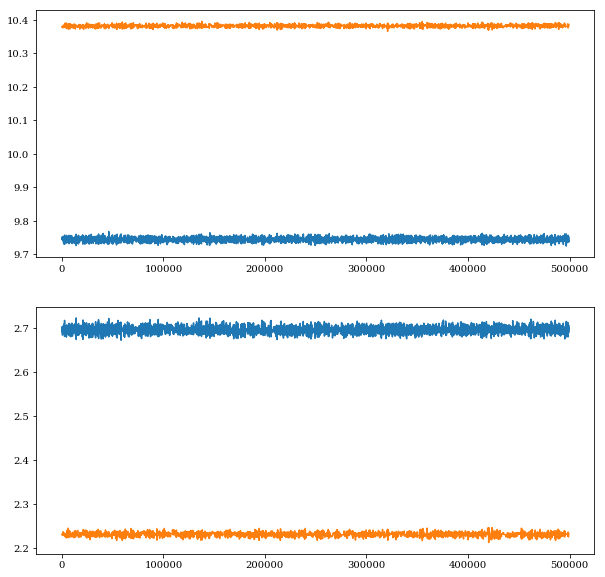

In [101]:
iteration = np.arange(0,len(logA),1)
iteration_piled = np.arange(0,len(logA_piled),1)
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
ax[0].plot(iteration,logA)
ax[0].plot(iteration_piled,logA_piled)

ax[1].plot(iteration,alpha)
ax[1].plot(iteration_piled,alpha_piled)

1000000 1000000
(1000000,) (1000000,)


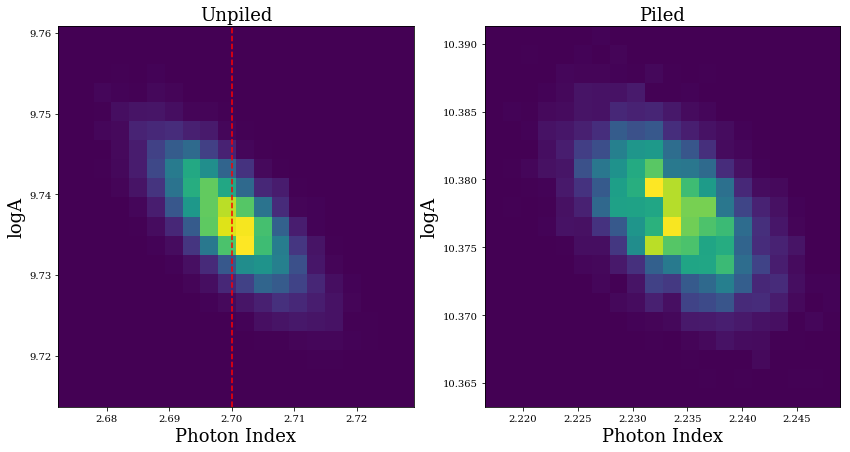

In [17]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
alph = np.array(alpha)
lA = np.array(logA)
print len(alph),len(lA)
print alph.shape,lA.shape
ax[0].hist2d(alph,lA,bins=[20,20])
#ax[0].scatter(2.69390499038,9.7461594902,marker='x',color='r',s=100)
ax[0].axvline(2.7,color='r',linestyle='--')
ax[0].set_xlabel('Photon Index',fontsize=18)
ax[0].set_ylabel('logA',fontsize=18)
ax[0].set_title('Unpiled',fontsize=18)

ax[1].hist2d(alpha_piled,logA_piled,bins=[20,20])
#ax[1].scatter(2.23238906282,10.3822305365,marker='x',color='r',s=100)
ax[1].axvline(2.7,color='r',linestyle='--')
ax[1].set_xlabel('Photon Index',fontsize=18)
ax[1].set_ylabel('logA',fontsize=18)
ax[1].set_title('Piled',fontsize=18)

plt.savefig('mcmc_heatmap.pdf')

In [33]:
abc_params = Table.read('part3_parameters.txt',format='ascii')

In [34]:
abc_params[:3]

alpha,obs_time
float64,float64
2.76075859786,52196.0
2.58647465061,49487.0
2.87722395185,52344.0


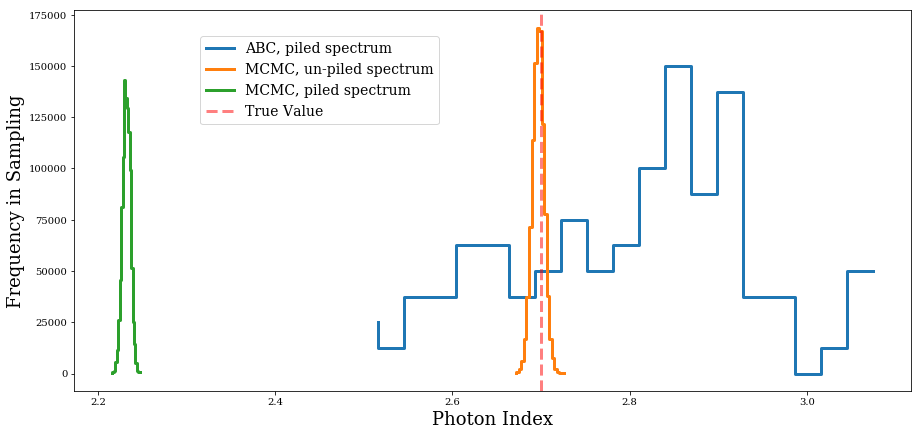

In [55]:
fig,ax=plt.subplots(figsize=(15,7))
unpiled_alpha,unpiled_bins = np.histogram(alpha,bins=20)
piled_alpha,piled_bins = np.histogram(alpha_piled,bins=20)
abc_alpha,abc_bins = np.histogram(abc_params['alpha'],bins=20)
ax.step(abc_bins[:-1],abc_alpha*12500,linewidth=3,label='ABC, piled spectrum')
ax.step(unpiled_bins[:-1],unpiled_alpha,linewidth=3,label='MCMC, un-piled spectrum')
ax.step(piled_bins[:-1],piled_alpha,linewidth=3,label='MCMC, piled spectrum')
ax.axvline(2.7,linewidth=3,linestyle='--',color='r',label='True Value',alpha=0.5)
ax.set_xlabel('Photon Index',fontsize=18)
ax.set_ylabel('Frequency in Sampling',fontsize=18)
ax.legend(fontsize=14,loc=(0.15,0.7))
plt.savefig('alpha_mcmc_abc.pdf')

(1000000, 2)


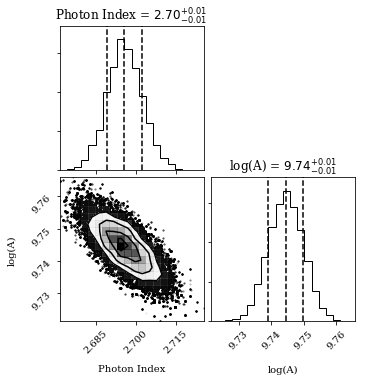

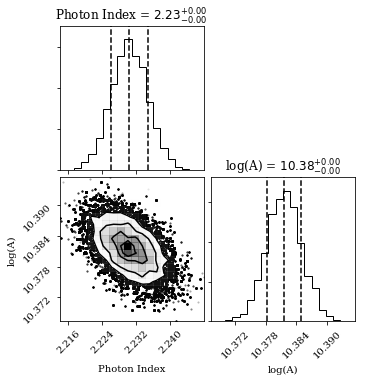

In [76]:
import corner

data = np.vstack((alpha,logA)).T
data_piled = np.vstack((alpha_piled,logA_piled)).T
print np.shape(data)

# Plot it.
#fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
figure1 = corner.corner(data, labels=["Photon Index", "log(A)"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
figure2 = corner.corner(data_piled, labels=["Photon Index", "log(A)"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [38]:
autocorr_func_1d(logA)

array([  1.00000000e+00,   9.86321158e-01,   9.72797456e-01, ...,
        -1.07638233e-08,  -7.17588221e-09,  -3.58794110e-09])

(0, 2000)

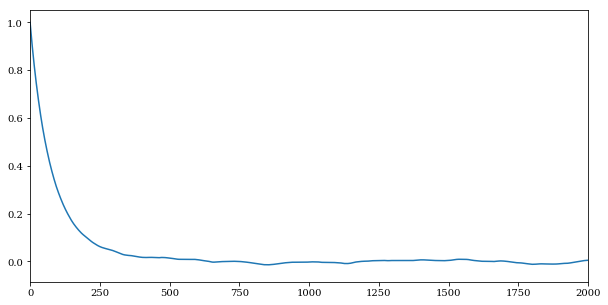

In [79]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(iteration,autocorr_func_1d(logA))
ax.set_xlim(0,2000)
#ax.set_ylim(-0.025,0.025)

In [33]:
autocorr_func_1d(alpha)[2000]

-0.0031522713262503309

In [4]:
#Metropolis-hastings using autocorrelation time rather than a defined number of steps.
def metropolis_hastings_acf(data,E_max,E_min):
    converged = 0
    step = 0
    #walk_length = 200

    #Run scipy.optimize.minimize on negative log likelihood to get starting values for random walk
    init_params = [np.log(1000000),2.0]
    opt = minimize(bayes.neg_log_likelihood,init_params,args=(data,E_max,E_min),method='Nelder-Mead',options={'disp': False})
    print('Starting values from scipy optimize: logA=',opt.x[0],'alpha=',opt.x[1])
    
    #Generate paramter space for logA and alpha
    sig_logA = 0.1 #These will need to be chosen more carefully eventually
    sig_a = 0.05 #These will need to be chosen more carefully eventually
        
    #Generate empty arrays for adding chain
    logA_vals = []
    alpha_vals = []
    post_vals = []
    
    #Define number of steps:
    #walk_length = 1000000
    
    #Take a random walk (in this case, just a finite number of steps)
    while converged==0:
        #print 'walk_length=',walk_length
        #print 'converged=',converged
        if step == 0:
            logA_vals.append(opt.x[0])
            alpha_vals.append(opt.x[1])
            log_like = bayes.log_likelihood([opt.x[0],opt.x[1]],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(opt.x[0])
            log_a_prior = bayes.log_prior_alpha(opt.x[1])
            running_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            post_vals.append(running_posterior)
            old_logA = opt.x[0]
            old_alpha = opt.x[1]
            print('Initial posterior value =',running_posterior)
            step += 1
            
        if step > 0:
            #if step%(walk_length/10)==0:
            #    print('on step',step)
            new_logA = np.random.normal(loc=logA_vals[-1],scale=sig_logA,size=1)
            new_a = np.random.normal(loc=alpha_vals[-1],scale=sig_a,size=1)
            log_like = bayes.log_likelihood([new_logA,new_a],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(new_logA)
            log_a_prior = bayes.log_prior_alpha(new_a)
            new_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            
            r = np.random.uniform(0.0,1.0)
            
            if np.exp(new_posterior-running_posterior)>r:
                logA_vals.append(new_logA)
                alpha_vals.append(new_a)
                post_vals.append(new_posterior)
                running_posterior = new_posterior
                old_logA = new_logA
                old_alpha = new_a
                step += 1
            else:
                logA_vals.append(logA_vals[-1])
                alpha_vals.append(alpha_vals[-1])
                post_vals.append(post_vals[-1])
                step += 1
        
        #Check ACF:
        acf_alpha = auto_corr.autocorr_func_1d(alpha_vals) 
        acf_logA = auto_corr.autocorr_func_1d(logA_vals)
        if ((acf_alpha[-1] < 0.01)&(acf_logA[-1] < 0.01)&(converged==0)):
            converged = 1
            print 'Chain has converged on step #',step
            tau = step
            walk_length = step + 10.0*step
            print 'new walk length =',walk_length

        else:
            converged = 0
                    
    return np.array(logA_vals[tau:]), np.array(alpha_vals[tau:]), np.array(post_vals[tau:])

In [82]:
test = np.linspace(0,800,20)
print test[2:]
print test

[  84.21052632  126.31578947  168.42105263  210.52631579  252.63157895
  294.73684211  336.84210526  378.94736842  421.05263158  463.15789474
  505.26315789  547.36842105  589.47368421  631.57894737  673.68421053
  715.78947368  757.89473684  800.        ]
[   0.           42.10526316   84.21052632  126.31578947  168.42105263
  210.52631579  252.63157895  294.73684211  336.84210526  378.94736842
  421.05263158  463.15789474  505.26315789  547.36842105  589.47368421
  631.57894737  673.68421053  715.78947368  757.89473684  800.        ]


In [7]:
logA,alpha,posteriors=metropolis_hastings_acf(energy_hist,ENERG_HI,ENERG_LO)

('Starting values from scipy optimize: logA=', 9.7378390630948974, 'alpha=', 2.6970722727412575)
('Initial posterior value =', -2029.25380210615)
Chain has converged on step # 32
new walk length = 352.0


auto_corr.py:28: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


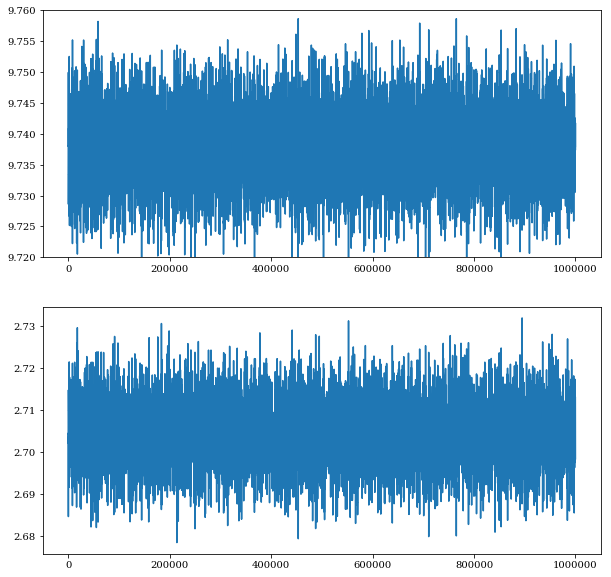

In [61]:
iteration = np.arange(0,len(logA),1)
#iteration_piled = np.arange(0,len(logA_piled),1)
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
ax[0].plot(iteration,logA)
ax[0].set_ylim(9.72,9.76)
#ax[0].plot(iteration_piled,logA_piled)

ax[1].plot(iteration,alpha)
#ax[1].plot(iteration_piled,alpha_piled)

In [69]:
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1
def autocorr_new(y, c=5.0):
    """
    from https://dfm.io/posts/autocorr/
    """
    f = np.zeros(len(y))
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

In [32]:
empty = []
phot_ind = float(np.random.uniform(0.5,5,1))
empty.append(phot_ind)
print empty

[1.1216606517394687]
